In [4]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.storages import RDBStorage

from sklearn.linear_model import LinearRegression

In [5]:
study_dir = '/mnt/nas/optuna_studies.db'

font_size = 16

In [21]:
storage = RDBStorage(url=f"sqlite:///{study_dir}")
study_summaries = optuna.get_all_study_summaries(storage=storage)
study_names = [summary.study_name for summary in study_summaries]
studies = [optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_dir}") for study_name in study_names]
entries = []
for study in studies:
    completed_trials = [trial for trial in study.trials if trial.value is not None and trial.state == optuna.trial.TrialState.COMPLETE]
    pruned_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.PRUNED]
    study_name = study.study_name
    study_setting = study_name[0:2]
    model_match = re.search(r'_m-([^_]+)', study_name)
    model_type = model_match.group(1) if model_match else None
    out_match = re.search(r'_out-([^_]+)', study_name)
    out_type = out_match.group(1) if out_match else None
    freq_match = re.search(r'_freq-([^_]+)', study_name)
    freq_type = freq_match.group(1) if freq_match else None
    additional = None
    if len(study_name.split('_')) > 4:
        additional = study_name.split('_')[-1]
    entry = {
        'study_name': study.study_name,
        'model': model_type,
        'setting': study_setting,
        'add': additional,
        'n_trials': len(study.trials),
        'n_compl_trials': len(completed_trials),
        'n_pruned_trials': len(pruned_trials),
        'best_value': round(study.best_trial.value, 4) if study.best_trial is not None else None,
    }
    entries.append(entry)
results = pd.DataFrame(entries)
#results_styled = results.style.set_properties(subset=['study_name'], **{'text-align': 'left'})
results

,study_name,model,setting,add,n_trials,n_compl_trials,n_pruned_trials,best_value
0,cl_d-pvod_m-tcn-gru_out-48_freq-1h,tcn-gru,cl,freq-1h,139,133,0,0.0057
1,cl_m-tcn-gru_out-48_freq-1h_00164,tcn-gru,cl,00164,788,154,632,0.0119
2,cl_m-tcn-gru_out-48_freq-1h_03362,tcn-gru,cl,03362,367,213,152,0.0185
3,cl_m-tcn-gru_out-48_freq-1h_03631,tcn-gru,cl,03631,298,132,161,0.0322
4,cl_m-tcn-gru_out-48_freq-1h_07370,tcn-gru,cl,07370,361,173,183,0.0312
5,cl_m-tft_out-48_freq-1h,tft,cl,None,95,5,2,0.0954
6,cl_m-tcn-gru_out-48_freq-1h_02638,tcn-gru,cl,02638,4,2,0,0.2318
7,cl_m-tcn-gru_out-48_freq-1h_02932,tcn-gru,cl,02932,2,1,0,0.2356
8,cl_m-tcn-gru_out-48_freq-1h_06163,tcn-gru,cl,06163,2,1,0,0.1236
9,cl_m-tcn-gru_out-48_freq-1h_07374,tcn-gru,cl,07374,2,1,0,0.0646


In [ ]:
study = study_summaries[0].study_name
#optuna.delete_study(study_name=study, storage=f"sqlite:///{study_dir}")

### Best Trial

In [18]:
for study in study_summaries:
    print(f'Best trial of {study.study_name}')
    trial = study.best_trial
    if not trial:
        print('No best trial for this.')
        continue
    print(f'  Error: {trial.value}')
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    print()

Best trial of cl_d-pvod_m-tcn-gru_out-48_freq-1h
  Error: 0.005732710938900709
  Params: 
    batch_size: 18
    epochs: 94
    lr: 0.0004083031076701365
    filters: 92
    kernel_size: 6
    n_cnn_layers: 10
    units: 230
    n_rnn_layers: 1

Best trial of cl_m-tcn-gru_out-48_freq-1h_00164
  Error: 0.011851449807484945
  Params: 
    batch_size: 49
    epochs: 98
    lr: 0.0012865236269198972
    filters: 118
    kernel_size: 2
    n_cnn_layers: 5
    dropout: 0.0014544331571957822
    units: 80
    n_rnn_layers: 1

Best trial of cl_m-tcn-gru_out-48_freq-1h_03362
  Error: 0.018466999133427937
  Params: 
    batch_size: 50
    epochs: 87
    lr: 0.0006886151747173739
    filters: 146
    kernel_size: 3
    n_cnn_layers: 5
    dropout: 0.006843160064693366
    units: 83
    n_rnn_layers: 1

Best trial of cl_m-tcn-gru_out-48_freq-1h_03631
  Error: 0.03222233181198438
  Params: 
    batch_size: 46
    epochs: 91
    lr: 0.0016347284342938307
    filters: 142
    kernel_size: 3
    n_cnn

In [19]:
def ten_best(study):
    trials = [trial for trial in study.trials if trial.value is not None and trial.state == optuna.trial.TrialState.COMPLETE]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    print("Top 10 Trials:", '\n')
    for trial in sorted_trials[:10]:
        print(f"Trial {trial.number}: MAE = {trial.value}")
        print(f"  Params: {trial.params}")
        print()

HPO Progess of cl_d-pvod_m-tcn-gru_out-48_freq-1h
Improvement per Trial: 0.0005603300180078321


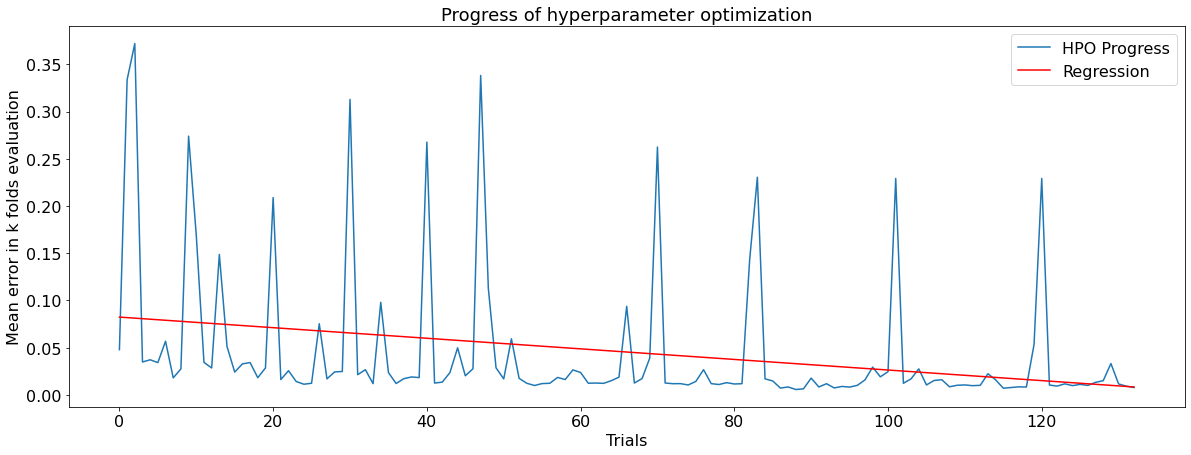

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_00164
Improvement per Trial: 0.00010738547126291388


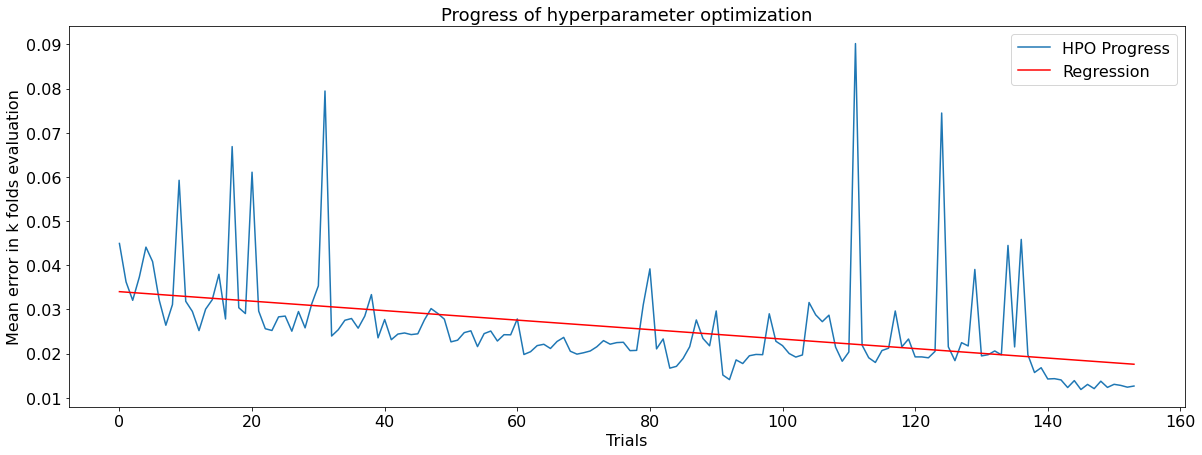

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_03362
Improvement per Trial: 0.00015746236669956647


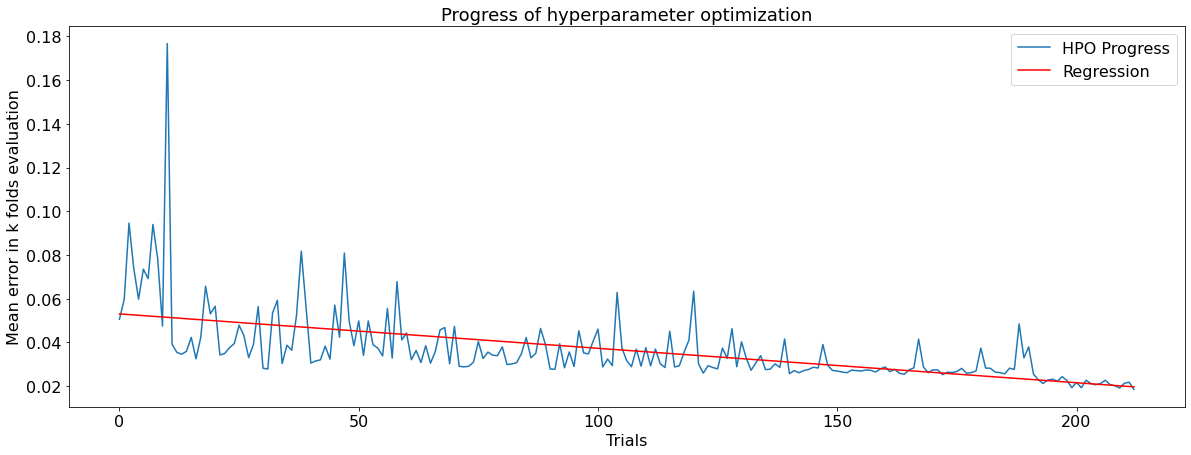

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_03631
Improvement per Trial: 0.00032572862284544797


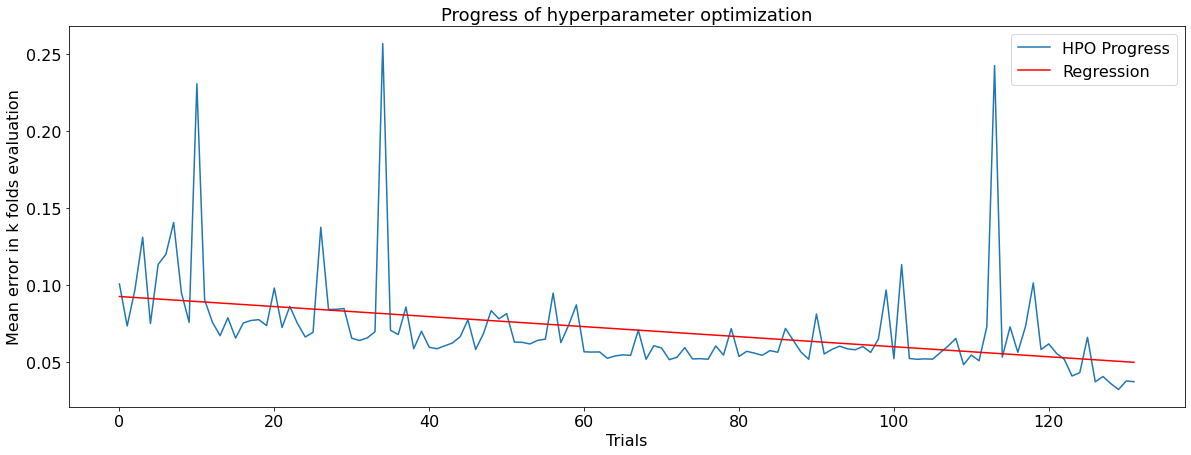

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_07370
Improvement per Trial: 0.00023701233859897095


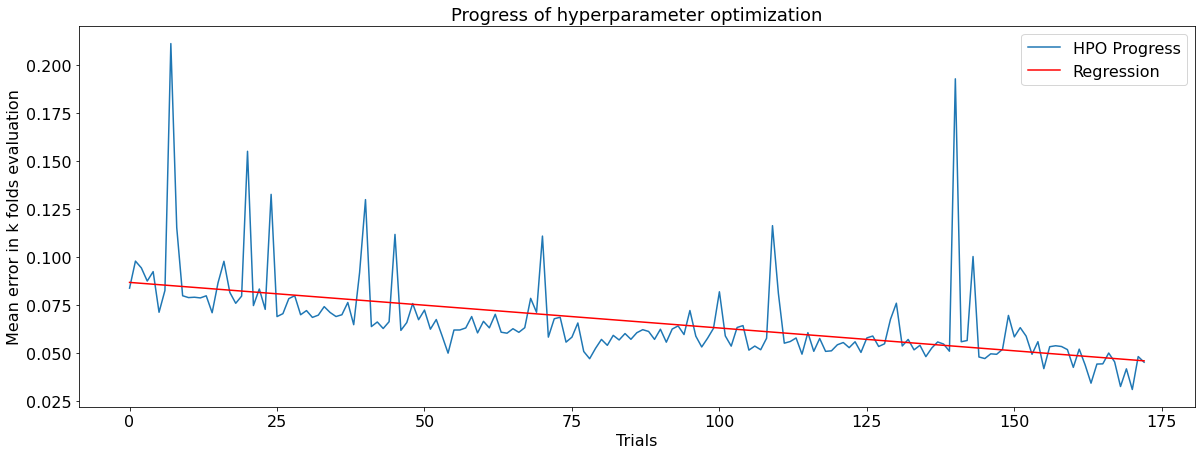

HPO Progess of cl_m-tft_out-48_freq-1h
Improvement per Trial: 0.0031037196516990654


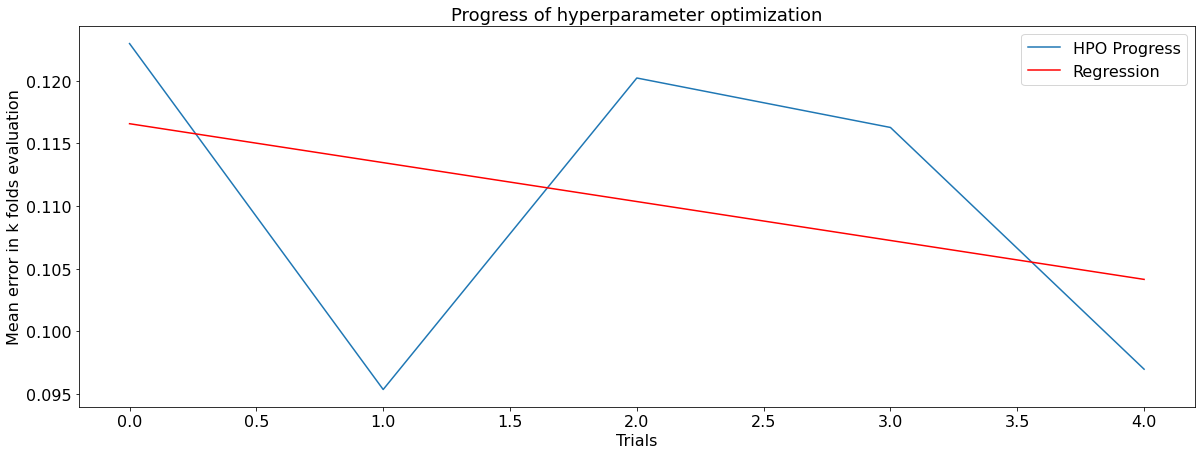

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_02638
Improvement per Trial: -0.15848456198970473


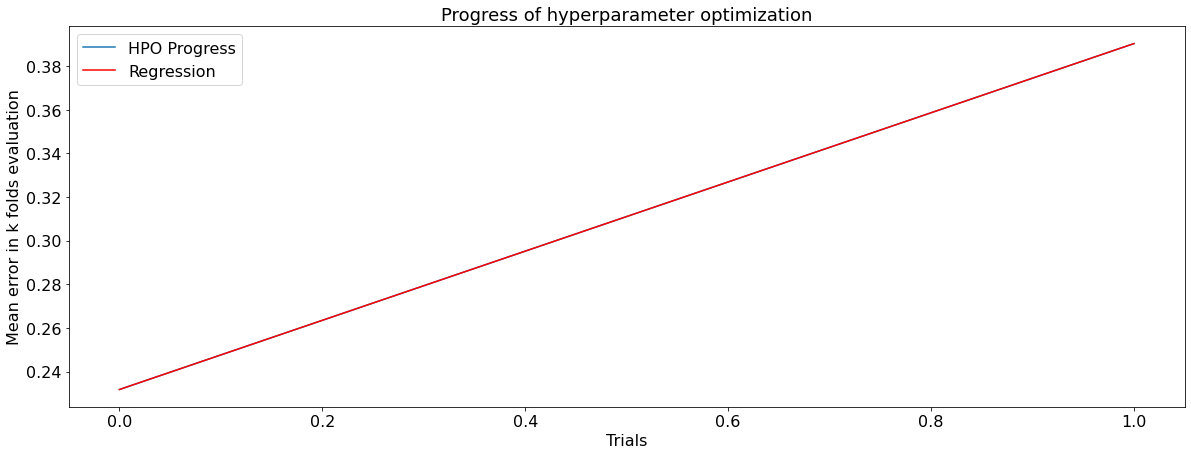

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_02932
Improvement per Trial: -0.0


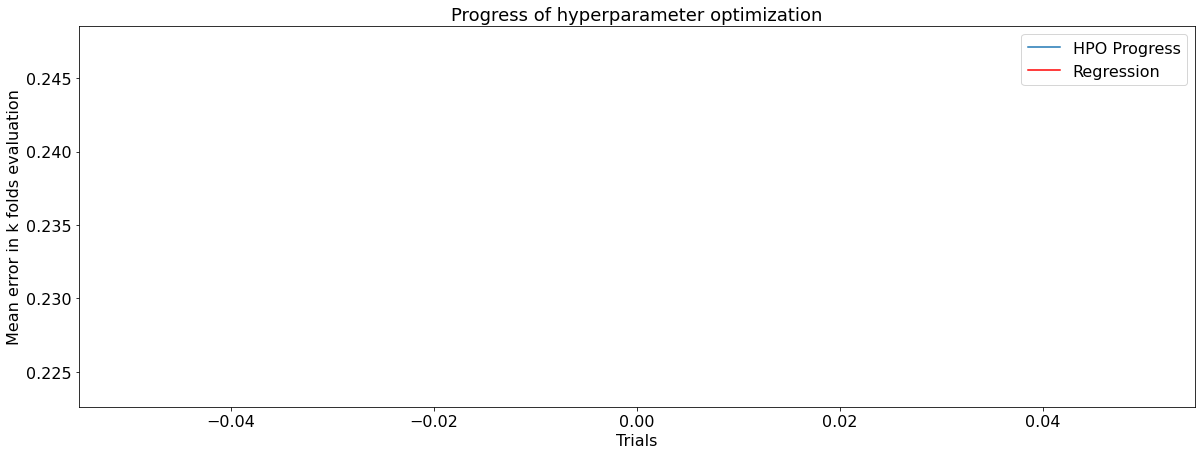

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_06163
Improvement per Trial: -0.0


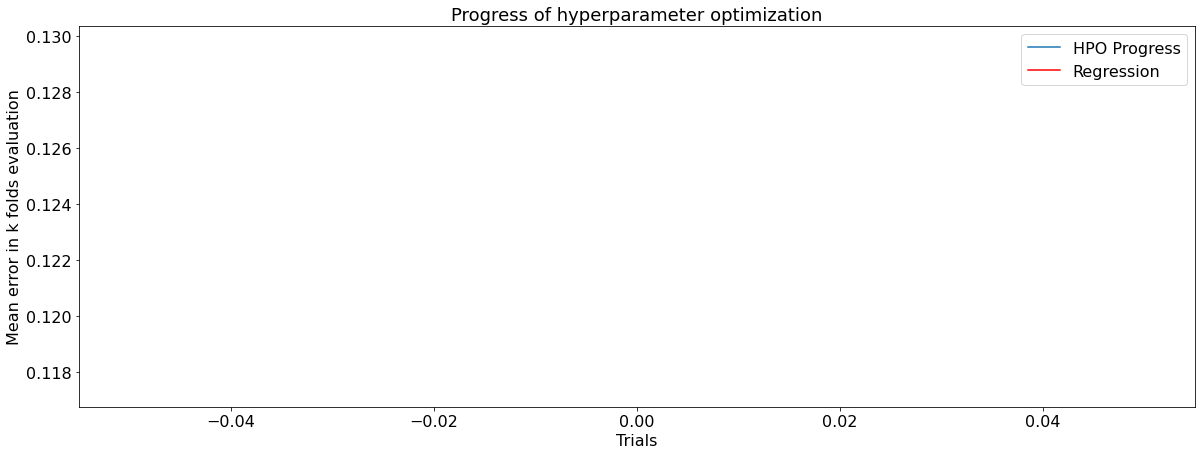

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_07374
Improvement per Trial: -0.0


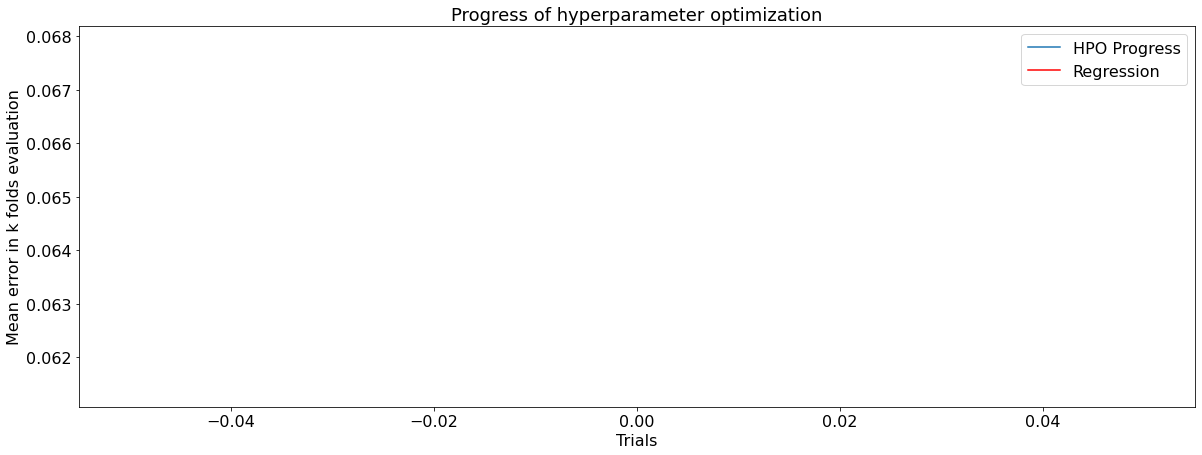

In [20]:
for study in studies:
    print(f'HPO Progess of {study.study_name}')
    trials = [trial for trial in study.trials if trial.value is not None and trial.state == optuna.trial.TrialState.COMPLETE]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    sorted_by_number = sorted(trials, key=lambda x: x.number)
    progress = [trial.values for trial in sorted_by_number]
    x = np.arange(len(progress)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, progress)
    y_pred = lr.predict(x)
    plt.figure(figsize=(20,7))
    print('Improvement per Trial:', lr.coef_[0][0]*-1)
    plt.plot(progress, label='HPO Progress')
    plt.plot(y_pred, 'r-', label='Regression')
    plt.title('Progress of hyperparameter optimization', fontsize=font_size+2)
    plt.xlabel('Trials', fontsize=font_size)
    plt.ylabel('Mean error in k folds evaluation', fontsize=font_size)
    ax = plt.gca()  # Get current axes
    ax.tick_params(axis='x', labelsize=font_size)  # Schriftgröße für x-Achsenmarkierungen
    ax.tick_params(axis='y', labelsize=font_size)
    #plt.yticks(np.arange(0,1,0.1))
    #plt.ylim(0,0.6)
    plt.legend(fontsize=font_size)
    plt.show()